# ground-segmentation

Learning a deep neural network for ground segmentation.

## Preprocessing

### Get dataset

In [1]:
from utils.get_dataset import get_cmu_corridor_dataset

get_cmu_corridor_dataset(dataset_path='./dataset')

Compressing dataset: 100%|██████████| 2906/2906 [00:01<00:00, 1465.94it/s]


### Load dataset

In [2]:
from utils.load_dataset import load_cmu_corridor_dataset

X_train, X_test, y_train, y_test = load_cmu_corridor_dataset(dataset_path='./dataset/cmu_corridor_dataset',
                                                             train_test_split=True,
                                                             image_size=(240, 320),
                                                             gray=False,
                                                             verbose=True)
print('X_train: %s, y_train: %s' % (X_train.shape, y_train.shape))
print('X_test: %s, y_test: %s' % (X_test.shape, y_test.shape))

Loading labels: 100%|██████████| 967/967 [00:00<00:00, 1794.08it/s]


X_train: (725, 240, 320, 3), y_train: (725, 240, 320, 1)
X_test: (242, 240, 320, 3), y_test: (242, 240, 320, 1)


### Insight dataset

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 8]

def plot_image(ax, img, title):
    ax.axis('off')
    ax.set_title(title)
    if img.shape[-1] == 1:
        img = img[..., 0]
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    
def plot_label(ax, label, title):
    ax.axis('off')
    ax.set_title(title)
    label = label[..., 0]
    ax.imshow(label, cmap='gray')
    
NUM_PLOTTING = 4

fig = plt.figure("Insight dataset")

images, labels = X_train, y_train

for index in range(NUM_PLOTTING):
    image, label = images[index], labels[index]
    image_title = '' if index != 0 else 'Raw image'
    label_title = '' if index != 0 else 'Ground segmentation'

    ax = fig.add_subplot(NUM_PLOTTING, 2, index*2 + 1)
    plot_image(ax, image, title=image_title)
    ax = fig.add_subplot(NUM_PLOTTING, 2, index*2 + 2)
    plot_label(ax, label, title=label_title)

plt.show()

<Figure size 500x800 with 8 Axes>

## Define Model

### unet

In [4]:
img_height, img_width, img_channel = X_train[0].shape

In [10]:
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import metrics
import numpy as np

# Compatible with tensorflow backend
def focal_loss(gamma=2., alpha=.75):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

def mean_IoU(target, pred):
    m = metrics.MeanIoU(num_classes=2)
    return m(target, pred > 0.5)

In [11]:
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from utils.unet import get_unet

input_img = Input((img_height, img_width, img_channel), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy",
              metrics=["accuracy", mean_IoU])
# model.compile(optimizer=Adam(), loss=focal_loss(gamma=2, alpha=.75),
#               metrics=["accuracy", mean_IoU])

In [12]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 240, 320, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 240, 320, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 240, 320, 16) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________________

## Training

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('models/model-gs-unet.h5', verbose=1, save_best_only=True, save_weights_only=False),
    TensorBoard(log_dir='.logs')
]

In [14]:
results = model.fit(X_train, y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Train on 725 samples, validate on 242 samples
Epoch 1/50
720/725 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.6947 - mean_IoU: 0.3308
Epoch 00001: val_loss improved from inf to 1.57364, saving model to models/model-gs-unet.h5
725/725 [==============================] - 13s 18ms/sample - loss: 0.6421 - accuracy: 0.6960 - mean_IoU: 0.3343 - val_loss: 1.5736 - val_accuracy: 0.8226 - val_mean_IoU: 0.5009
Epoch 2/50
720/725 [============================>.] - ETA: 0s - loss: 0.4394 - accuracy: 0.8856 - mean_IoU: 0.5524
Epoch 00002: val_loss improved from 1.57364 to 0.63170, saving model to models/model-gs-unet.h5
725/725 [==============================] - 11s 15ms/sample - loss: 0.4391 - accuracy: 0.8858 - mean_IoU: 0.5531 - val_loss: 0.6317 - val_accuracy: 0.7917 - val_mean_IoU: 0.5871
Epoch 3/50
720/725 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8972 - mean_IoU: 0.6078
Epoch 00003: val_loss improved from 0.63170 to 0.50555, saving mode

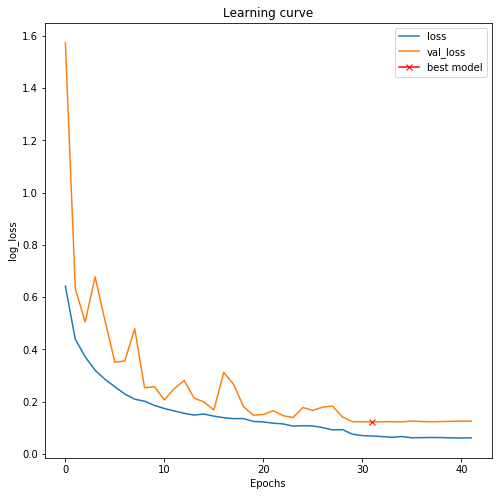

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## Inference

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics

from tensorflow.keras.models import load_model

model = load_model('models/model-gs-unet.h5', compile=False)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", mean_IoU])

In [17]:
# Evaluate on train set (this must be equals to the best log_loss)
model.evaluate(X_train, y_train, verbose=1)

725/725 [==============================] - 4s 5ms/sample - loss: 0.0635 - accuracy: 0.9779 - mean_IoU: 0.9362


[0.06354035591770862, 0.977896, 0.9362259]

In [18]:
# Evaluate on test set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

242/242 [==============================] - 1s 5ms/sample - loss: 0.1226 - accuracy: 0.9547 - mean_IoU: 0.9267


[0.12264477036708643, 0.9546653, 0.9266768]

In [19]:
# Predict on train and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

242/242 [==============================] - 1s 3ms/sample


### Predictions on training set

In [20]:
from utils.plot import plot_samples

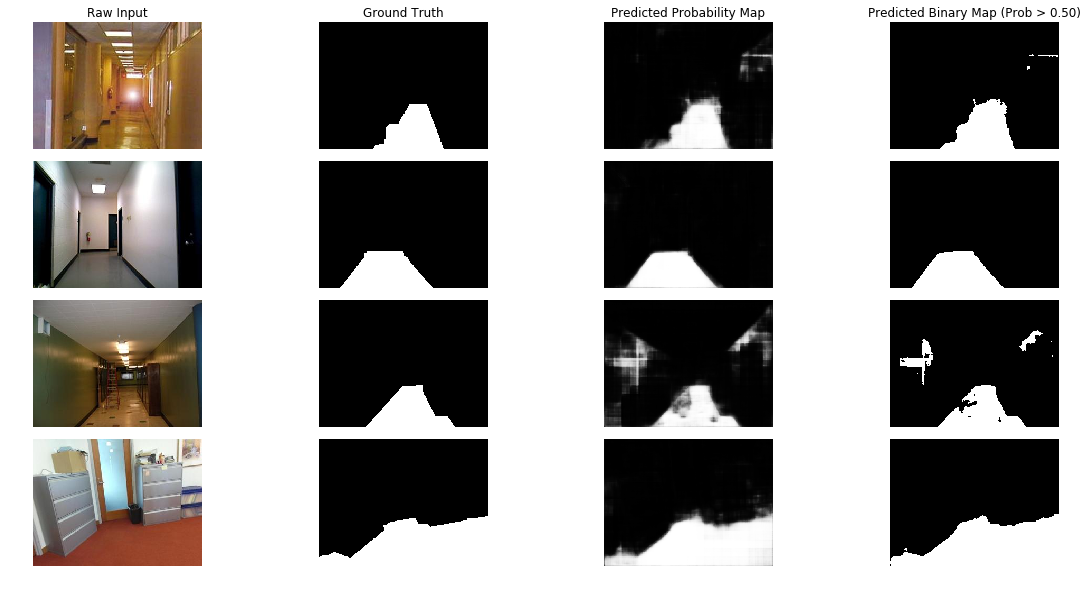

In [21]:
plot_samples(X_train, y_train, preds_train, num_samples=4, prob=0.5, seed=1)

### Predictions on test set

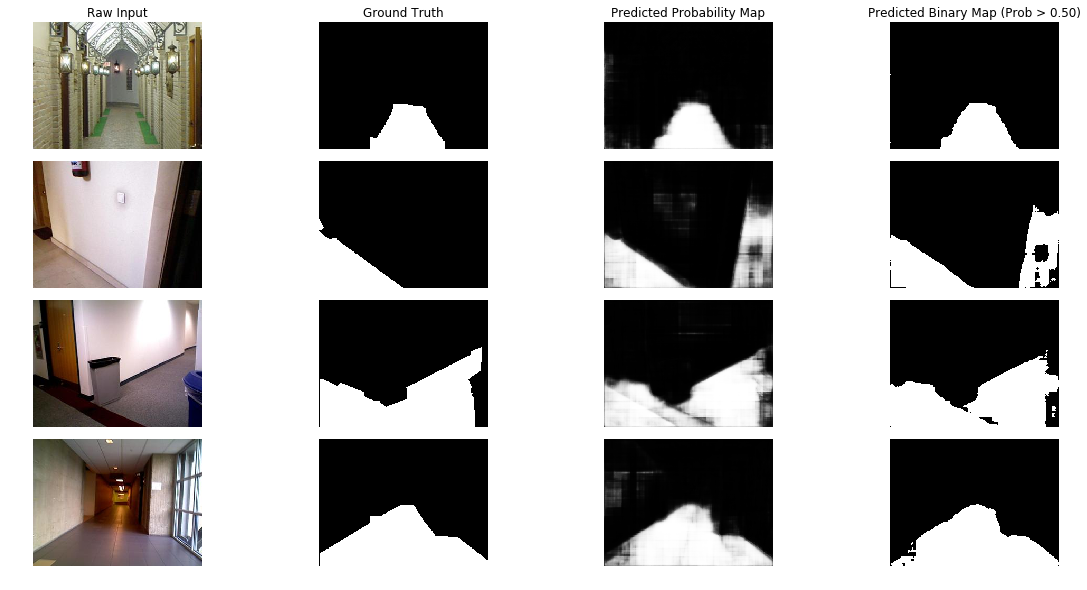

In [22]:
plot_samples(X_test, y_test, preds_test, num_samples=4, prob=0.5, seed=1)

### Predictions on selected images

In [23]:
import glob
from path import Path
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

DEMO_PATH = Path('./demo')

image_files = glob.glob(DEMO_PATH / '*.*')
X_misc = np.zeros((len(image_files), img_height, img_width, img_channel), dtype=np.float32)

for i, image_file in enumerate(tqdm_notebook(image_files, total=len(image_files), desc="Loading images")):
    img = load_img(image_file, grayscale=False if img_channel == 3 else True)
    x_img = img_to_array(img)
    x_img = tf.image.resize(x_img, (img_height, img_width))
    X_misc[i] = x_img / 255.0

In [24]:
preds_misc = model.predict(X_misc, verbose=1)

9/9 [==============================] - 0s 39ms/sample


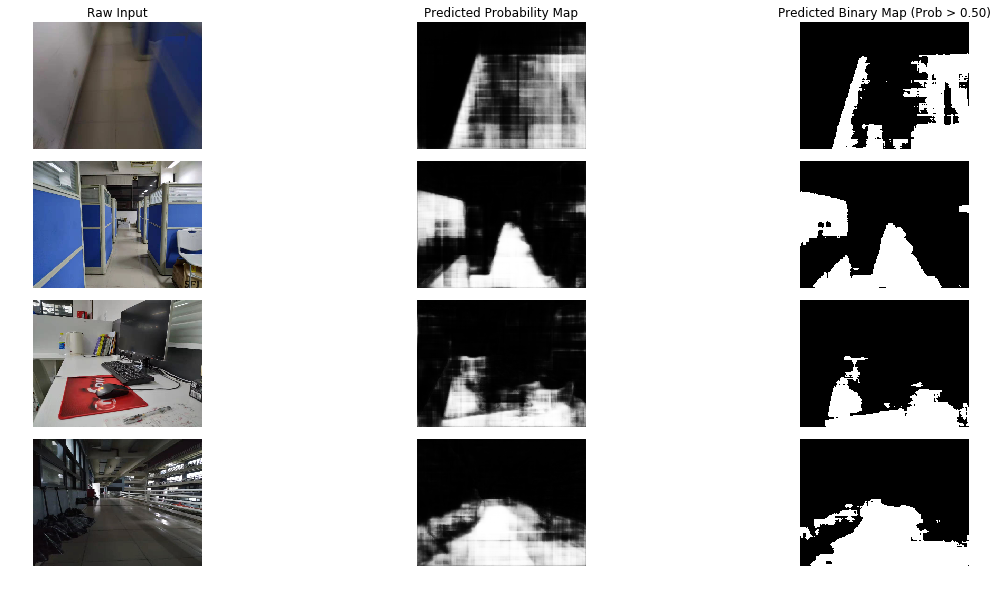

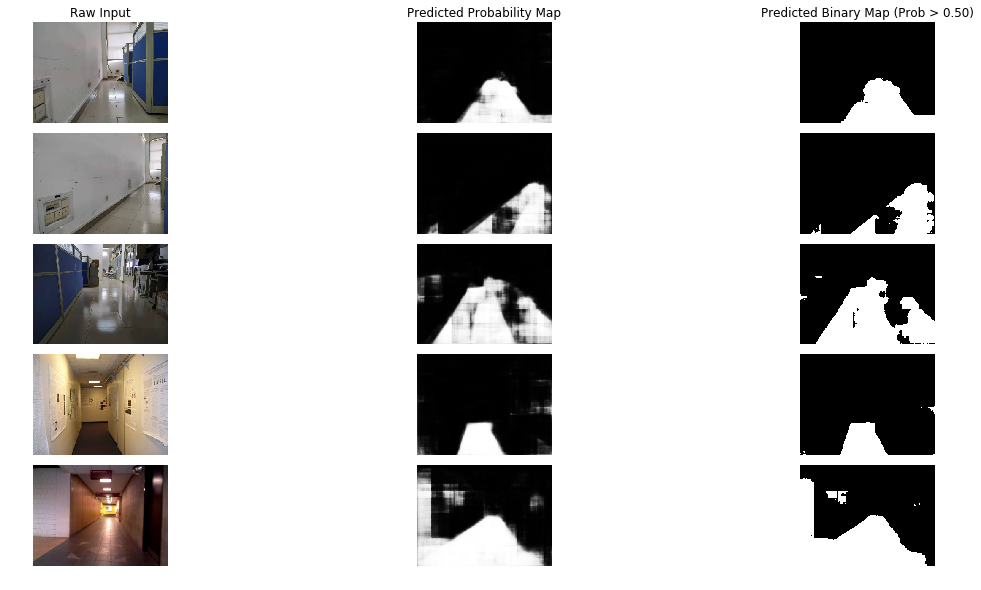

In [25]:
indexs = list(range(len(X_misc)))

plot_samples(X_misc, None, preds_misc, indexs=indexs[:len(indexs)//2], prob=0.5)
plot_samples(X_misc, None, preds_misc, indexs=indexs[len(indexs)//2:], prob=0.5)

In [26]:
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.image import resize
import os

OUTPUT_PATH = DEMO_PATH / 'predict'

if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)

binary_preds = (preds_misc > 0.5).astype(np.uint8)
for index, (image, label) in enumerate((tqdm_notebook(zip(X_misc, binary_preds), total=len(X_misc), desc="Saving images and labels"))):
    image_fname = OUTPUT_PATH / 'rgb_%04d.png' % index
    label_fname = OUTPUT_PATH / 'label_%04d.png' % index
    
    image = resize(image, (480, 640))
    save_img(image_fname, image, scale=True)
    
    label = resize(label, (480, 640))
    save_img(label_fname, label, scale=True)